For $N_i$ fixed ions of charge $+Ze$ and $N_e$ electrons of charge $-e$ travelling in random directions at speed $v$, accelerating electrons emit isotropically.
$$\frac{\epsilon_{\nu}}{4\pi} = \frac{8 Z^2 e^6}{3m^2 v c^3}N_i N_e \frac{\pi}{\sqrt{3}}g_{ff}$$

Since unbound, use an analogous quantum number $\eta$ such that the initial state $E_i = Z^2 I_0 / \eta^2$ and the final energy state is $E_f = Z^2 I_0 / \eta'^2$, for $I_0 = m e^4 / (2\hbar)^2$. With manipulation, $\eta = Z \alpha / \beta$ and $\eta' = Z \alpha / \sqrt{\beta^2 + 2 \alpha^2 E_f}$ with corresponding wavenumbers.

Quantum Woo $\rightarrow$ analytical continuation garbage that doesn't really matter understand $g_{ff}$, which is a ratio of the QM cross-section and the semi-classical derived cross-section.

$$g_{ff} =\frac{2\sqrt{3}}{\pi \eta_i \eta_f}[(\eta_i^2 + \eta_f^2 + 2\eta_i^2\eta_f^2)I_0 - 2\eta_i\eta_f(1+\eta_i^2)^{1/2}(1+\eta_f^2)^{1/2}I_1]I_0$$
Where $I_l$ has some functional form.

In [1]:
import numpy as np
from scipy import constants
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
from mpmath import hyp2f1, factorial, gamma
fsc = constants.alpha   
aB_in_cm = constants.value('Bohr radius') * 1e2
c = constants.c * 1.e2
e_e = 4.80320451e-10
m_e = constants.electron_mass * 1e3
k = 1.380648780669e-16

In [2]:
def I(eta_i, eta_f, k_i, k_f, l):
    """something dumb (radial-dipole integral)
    
    Arguments:
    eta_i  : modified quantum number associated with initial energy
    eta_f  : modified quantum number associated with final energy
    k_i    : wavenumber associated with initial energy
    k_f    : wavenumber associated with final energy
    l      : azimuthal quantum number
    
    Returns:
    I_l    : some number.
    """
    temp1 = 1/4*(4.* k_i * k_f / (k_i - k_f)**2)**(l+1) 
    temp2 = np.exp(np.pi/2*abs(eta_i - eta_f))
    temp3 = abs(gamma(l+1+1j*eta_i) * gamma(l+1+1j*eta_f)) / gamma(2.*l + 2)
    return temp1 * temp2 * temp3 *G(eta_i, eta_f, k_i, k_f, l)

def G(eta_i, eta_f, k_i, k_f, l):
    """something dumb helper"""
    temp1 = abs((k_f - k_i) / (k_f + k_i))**(1j*eta_i + 1j*eta_f)
    temp2 = hyp2f1(l+1-1j*eta_f, 
                   l+1-1j*eta_i, 
                   2.*l+2, 
                   -4.*k_i*k_f/(k_i-k_f)**2)

    return (temp1 * temp2).real

In [3]:
def gaunt_free_free(Z, beta, E):
    """calculate the Gaunt factor for free-free emission
    
    Arguments:
    Z    : ion charge, int
    beta : velocity of incident electron in units of c, float or array
    E    : energy of photon in units of Ha, float or array
    
    Returns:
    g_ff : gaunt factor for free-free emission"""
    
    eta_i = Z * fsc / beta
    k_i = Z / eta_i / aB_in_cm
    eta_f = Z * fsc / (beta**2 + 2*E*fsc**2)**.5
    k_f = Z / eta_f / aB_in_cm

    I0 = I(eta_i, eta_f, k_i, k_f, 0)
    I1 = I(eta_i, eta_f, k_i, k_f, 1)
    
    out = 2*3**.5/np.pi/eta_i/eta_f * I0
    out *=((eta_i**2 + eta_f**2 + 2*eta_i**2*eta_f**2)*I0 - 2 * eta_i * eta_f * (1 + eta_i**2)**.5*(1+eta_f**2)**.5*I1)

    return out.real

In [4]:
def free_free_emission_spectrum(Z, hnu, E):
    """calculate free-free spectrum
    
    Arguments:
    Z    : ion charge, int
    hnu  : energy of emitted photon, in Ha
    E    : electron final energy, in Ha"""
    if hnu >= E:
        return 0.
    g_ff = gaunt_free_free(Z, fsc * (2*(E - hnu))**.5, hnu)
    return 64 * np.pi**2 / 3 / 3**.5 * Z**2 * fsc**3 / (2*E)**.5 * g_ff

The free-free emission per unit volume of a thermal gas is obtained averaging over a Maxwellian distribution, $f(E) \propto \sqrt{E} exp(-E/T)$

In [5]:
def free_free_thermal_spectrum(Z, T, E):
    """calculate free-free spectrum
    from an ensemble of electrons following a Maxwellian
    
    Arguments:
    Z    : ion charge, int
    T    : temperature of electrons, in Ha
    E    : energies of emitted photons, in Ha
    """
    out = np.zeros_like(E)
    for i, hnu in enumerate(E):
        out[i] = scipy.integrate.quad(lambda x: x**.5 * np.exp(-x / T) * free_free_emission_spectrum(Z, hnu, x), hnu, np.inf)[0]
        out[i] /= scipy.integrate.quad(lambda x: x**.5 * np.exp(-x / T), 0, np.inf)[0]
    return out

Emissivity $\epsilon_{\nu}$ of free-free emission from an ensemble of electrons therefore is proportional to the velocitiy weighted Gaunt factor.
$$\epsilon_{\nu,ff} = \frac{1}{2\pi}\frac{2^5 Z^2 e^6}{3 \sqrt{3} m^2 c^3}N_i N_e \frac{\int_{h\nu}^{\infty}g(E, \nu) e^{-E / k T} dE}{\int_{0}^{\infty}\sqrt{E} e^{-E / k T} dE} = \frac{1}{2\pi}\frac{2^5 Z^2 e^6}{3 m c^3}N_i N_e \bigg(\frac{2\pi}{3 k T m}\bigg)^{1/2} e^{-h \nu / k T} \bar{g}_{ff}$$

I am putting emissivity in cgs units.

In [6]:
def emissivity_free_free(Z, Ni, Ne, T, nu):
    """calculate emissivity of free free emission
    
    Arguments:
    Z    : ion charge, int
    Ni   : ion density, in cm^-3
    Ne   : electron density, in cm^-3
    T    : temperature of electrons, in K
    nu   : frequency, in Hz
    """
    T_Ha = T * 3.16680853419133e-6
    hnu_Ha = nu * 1.519828500715e-16
    
    term = scipy.integrate.quad(lambda x:np.exp(-x/T_Ha) * gaunt_free_free(Z, fsc*(2*(x-hnu_Ha))**.5, hnu_Ha), hnu_Ha, np.inf)[0]
    term /= scipy.integrate.quad(lambda x: x**.5 * np.exp(-x/T_Ha), 0, np.inf)[0]
    # the exponential is folded into the numerator
    
    prefactor = 2**5 * np.pi * Z**2 * e_e**6 / 3 / m_e / c**3
    temp2 = (2 * np.pi / 3 /k/m_e/T)**.5
    return 1/2/np.pi*Ni*Ne*prefactor*temp2*term

In [7]:
test = []
for nu in np.logspace(np.log10(3e13),np.log10(3e15),200):
    test.append(nu * emissivity_free_free(1, 1, 1, 10000, nu))

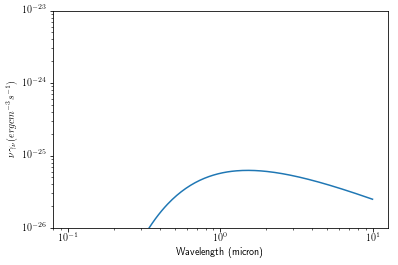

In [8]:
plt.loglog(3e14/np.logspace(np.log10(3e13),np.log10(3e15),200), np.array(test))
plt.ylim(1e-26,1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (erg cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')

In [17]:
Z = 1.0
energies = np.logspace(-5,8,101) # Ry
velocities = np.sqrt(energies*fsc**2) # Ha
photon_energies = np.logspace(-6,8, 15) # Ry

gff1 = np.asarray([[gaunt_free_free(Z, v, photon_energy) for v in velocities] for photon_energy in photon_energies])


In [37]:
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

(1e-05, 10000000.0)

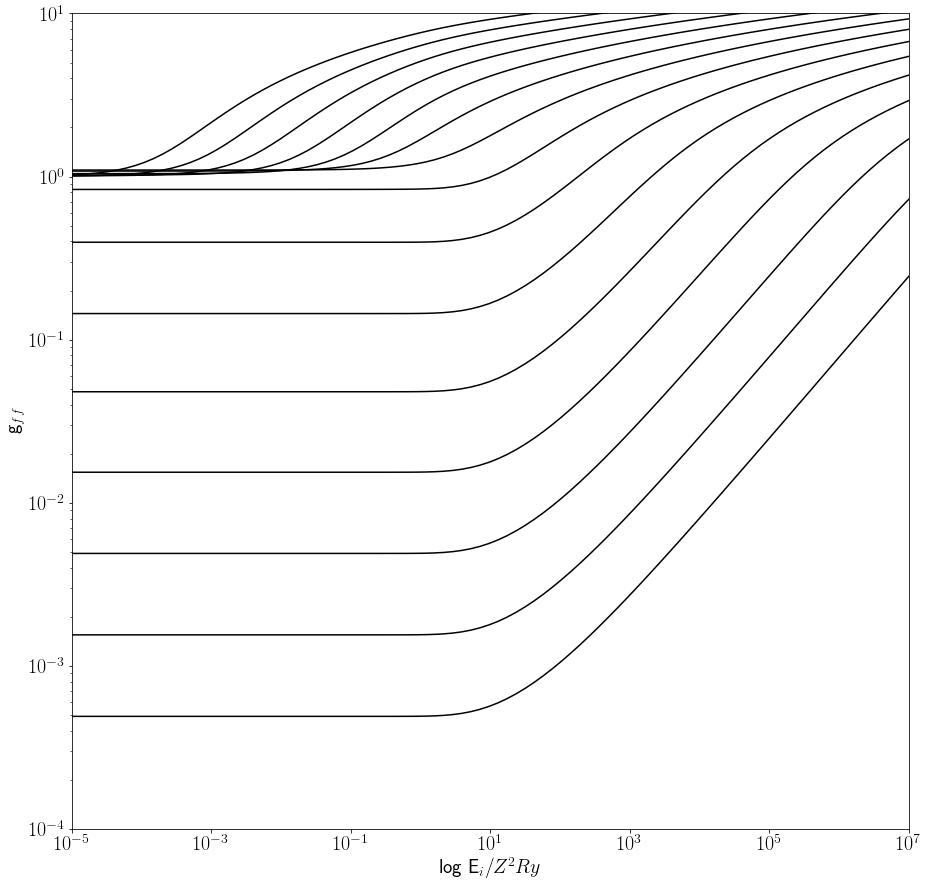

In [38]:
plt.figure(figsize=(15,15))
[plt.loglog(energies, gff1[i],'k') for i in range(len(photon_energies))]
plt.xlabel(r'log E_i/Z^2 Ry', fontsize=20)
plt.ylabel(r'g_{ff}', fontsize=20)
plt.ylim(1e-4,10)
plt.xlim(1e-5,1e7)

In [39]:
Z = 1.0
energies = np.logspace(-5,8,14) # Ry
velocities = np.sqrt(energies*fsc**2) # Ha
photon_energies = np.logspace(-6,8, 101) # Ry

gff2 = [[gaunt_free_free(Z, v, photon_energy/2.) for photon_energy in photon_energies] for v in velocities]

(1e-05, 100000000.0)

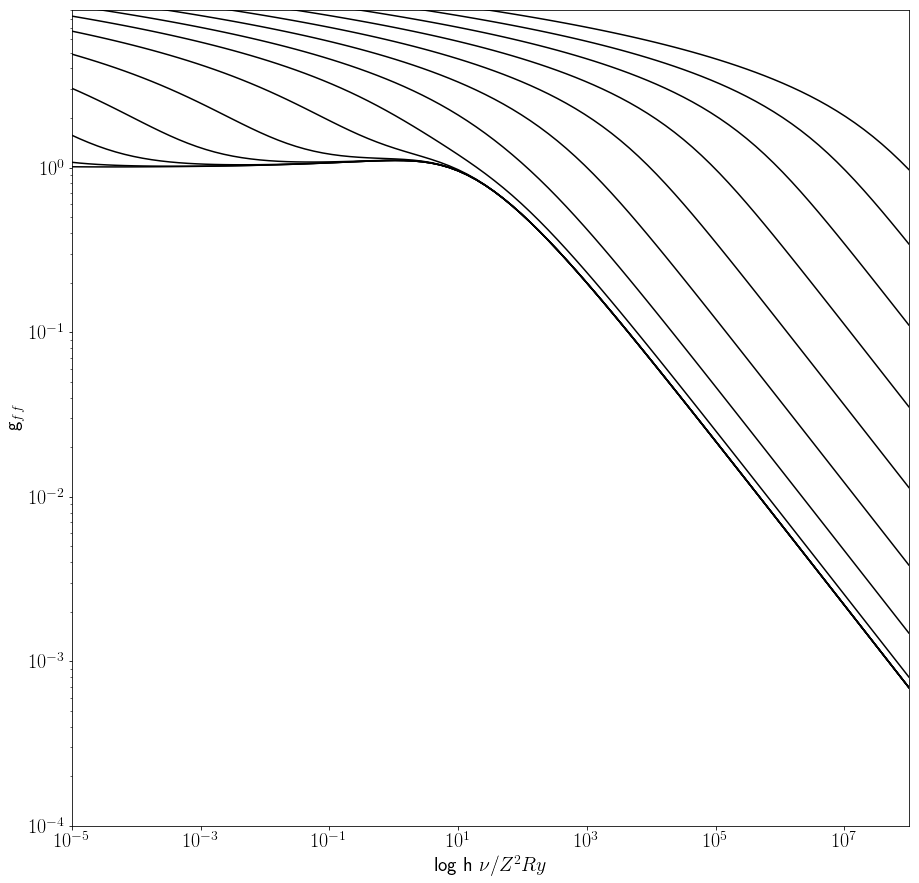

In [42]:
plt.figure(figsize=(15,15))
[plt.loglog(photon_energies, gff2[i],'k') for i in range(len(velocities))]
plt.xlabel(r'log h \nu / Z^2 Ry', fontsize=20)
plt.ylabel(r'g_{ff}', fontsize=20)
plt.ylim(1e-4,9)
plt.xlim(1e-5,1e8)